# Imports

In [122]:
import pandas as pd
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np


# Train and test

## Functions

In [123]:
def split_data(df):
    # Filter the rows based on the 'confID_EA' and 'confID_EW' values
    confEA_data = df[df['confID_EA'] == 1]
    confEW_data = df[df['confID_WE'] == 1]

    return confEA_data, confEW_data
    

In [124]:
df_teams=pd.read_csv('data_merged.csv')
df_teams = df_teams[df_teams['year'] != 1]

df_teams.drop(columns=['tmID'], inplace=True)
df_teams.head()


,year,playoff,confID_EA,confID_WE,total_wins,total_losses,GP,GS,minutes,points,...,height,weight,award_count_x,won,lost,post_wins,post_losses,award_count_y,W,L
16,2,1,1.0,0.0,0.0,0.0,28.888889,13.555556,636.555556,217.666667,...,71.333333,166.111111,0.000000,9.0,23.0,0.0,0.0,0.0,0.0,0.0
17,2,1,1.0,0.0,2.0,1.0,24.769231,10.000000,483.153846,160.307692,...,71.538462,168.538462,0.000000,17.0,15.0,3.0,3.0,0.0,3.0,3.0
18,2,0,1.0,0.0,0.0,0.0,28.571429,21.428571,688.571429,255.142857,...,71.857143,166.857143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2,1,0.0,1.0,6.0,0.0,25.714286,13.428571,507.428571,162.714286,...,72.428571,172.571429,0.142857,27.0,5.0,6.0,0.0,0.0,6.0,0.0
20,2,0,1.0,0.0,0.0,0.0,29.400000,14.000000,621.900000,206.000000,...,71.800000,166.600000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No need to sample the data, as it is balanced.

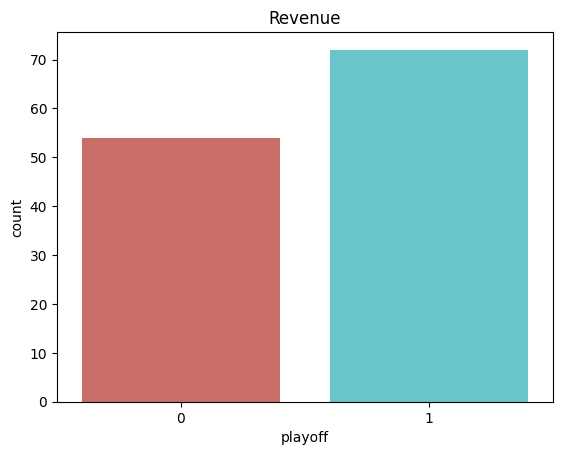

In [125]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [126]:
from sklearn.decomposition import PCA

def split_and_train(year, model, data, target_col="playoff", scaling=False):
        # Split the data into training and test sets
        train_data = data[data["year"] < year ]
        test_data = data[data["year"] == year ]


        if(scaling):
            scaler = MinMaxScaler()
            train_data = scaler.fit_transform(train_data)
            train_data = pd.DataFrame(train_data, columns=data.columns)
            test_data = scaler.transform(test_data)
            test_data = pd.DataFrame(test_data, columns=data.columns)


        X_train = train_data.drop([target_col], axis=1)
        y_train = train_data[target_col]
        X_test = test_data.drop([target_col], axis=1)
        y_test = test_data[target_col]

        #PCA
        # pca = PCA(n_components=28, svd_solver='full')
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        # Create and train the decision tree model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        #y_pred = model.predict(X_test)
        # Make probability predictions on the test set
        # Sort the probabilities in reverse order and get the indices
        y_prob = model.predict_proba(X_test)
        sorted_indices = np.argsort(-y_prob[:, 1])
        print(sorted_indices)

        # Set the top 4 predictions with target 1 and others with target 0
        y_pred = np.zeros_like(y_test)
        y_pred[sorted_indices[:4]] = 1
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob[:, 1]})


        return y_test, y_pred, y_prob[:, 1]
        


def train_evaluate_decision_tree_graph(model, data, target_col="playoff", scaling=False):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    years_tested = []

    # Sort the data by the "year" column
    data = data.sort_values(by="year")
    data1, data2 = split_data(data)
    years = sorted(data["year"].unique())

    for year in years[3:]:
       
        y_test1, y_pred1, y_prob1 = split_and_train(year, model, data1, target_col, scaling)
        y_test2, y_pred2, y_prob2 = split_and_train(year, model, data2, target_col, scaling)
        # Merge of 
        # Join y_test1 and y_test2
        y_test = np.concatenate([y_test1, y_test2])

        # Join y_pred1 and y_pred2
        y_pred = np.concatenate([y_pred1, y_pred2])
        
        y_prob = np.concatenate([y_prob1, y_prob2])
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob})

        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        years_tested.append(year)
        

    return years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores


In [127]:
def plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores):
    # Create a graph to plot accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(20, 5))

    # Plot accuracy
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores, marker='o')
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot precision
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores, marker='o', color='orange')
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot recall
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores, marker='o', color='green')
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot f1
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores, marker='o', color='red')
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    plt.tight_layout()
    plt.show()
    
    # Calculate means
    accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)
    precision_mean = sum(precision_scores) / len(precision_scores)
    recall_mean = sum(recall_scores) / len(recall_scores)
    f1_mean = sum(f1_scores) / len(f1_scores)

    print("Accuracy: ", accuracy_mean)
    print("Precision: ", precision_mean)
    print("Recall: ", recall_mean)
    print("F1: ", f1_mean)


## Models

### Desicion Tree

#### Hyperparameter tuning

In [128]:
from  sklearn.model_selection import GridSearchCV

# model = DecisionTreeClassifier()
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4, 5 ],
#                 'criterion': ['gini', 'entropy', 'log_loss'],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'splitter': ['best', 'random'],
                
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_)
#DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=6,splitter='random')


[0 1 3 4 2 5]
[0 1 2 3 4 6 5]
[1 2 3 4 0 5]
[1 3 4 5 0 2 6]
[0 2 3 4 1 5 6]
[0 2 5 6 1 3 4]
[0 1 2 3 4 5]
[0 2 4 5 6 1 3]
[0 1 2 3 4 5 6]
[0 1 4 6 2 3 5]
[2 3 4 5 0 1 6]
[0 2 4 5 1 3]


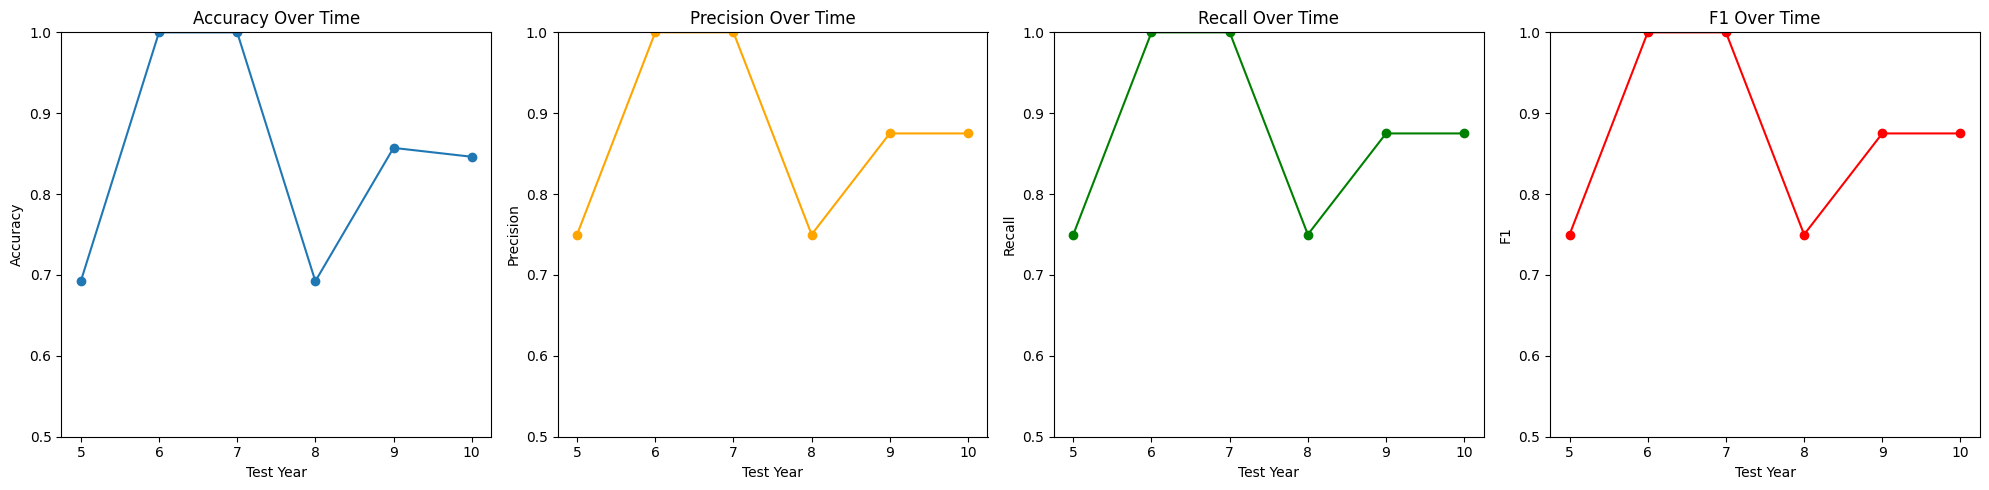

Accuracy:  0.847985347985348
Precision:  0.875
Recall:  0.875
F1:  0.875


In [129]:
model = DecisionTreeClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

### Random Forest

#### Hyperparameter tuning

In [130]:
from sklearn.model_selection import RandomizedSearchCV

# model = RandomForestClassifier()

# param_grid = {'max_depth': [4, 6, 10, 100, 200, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4 ],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'max_leaf_nodes': [None,  6, 7, 10, 20],
#                 'min_impurity_decrease': [0, 0.1, 0.2],
#                 'bootstrap': [False],
#                 'class_weight': ['balanced', 'balanced_subsample', None],
#                 'n_jobs': [None, 2, 3],                
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)


In [131]:
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, class_weight='balanced',
#                        criterion='entropy', max_leaf_nodes=6,
#                        min_impurity_decrease=0.2, min_samples_leaf=4, n_jobs=2) 0.8895384615384616
#                       min_samples_leaf=2, min_samples_split=4, n_jobs=2) 0.8895384615384616
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, class_weight='balanced',
#                        criterion='log_loss', max_depth=10, max_features=None,
#                         max_leaf_nodes=6, min_impurity_decrease=0.2, n_jobs=2) 0.8818461538461537
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, criterion='log_loss',
#                        max_depth=2, max_features='log2', max_leaf_nodes=7,
#                        min_impurity_decrease=0.2, min_samples_leaf=2) 0.8975384615384616
# RandomForestClassifier(ccp_alpha=0.2, max_depth=100, min_impurity_decrease=0,
#                        min_samples_split=4, n_jobs=2, oob_score=True,
#                        warm_start=True) 0.8975384615384616
# RandomForestClassifier(ccp_alpha=0, max_depth=100, max_features=None,
#                        min_impurity_decrease=0, min_samples_leaf=3,
#                        min_samples_split=6, n_jobs=3) 0.8821538461538461


[3 4 1 0 2 5]
[6 0 1 3 2 4 5]
[3 4 1 2 0 5]
[5 1 4 3 0 6 2]
[4 2 1 3 0 5 6]
[2 0 5 6 1 3 4]
[4 3 2 1 0 5]
[4 0 1 2 6 5 3]
[3 2 4 1 0 5 6]
[4 0 6 1 2 5 3]
[3 2 4 5 0 1 6]
[5 2 0 4 3 1]


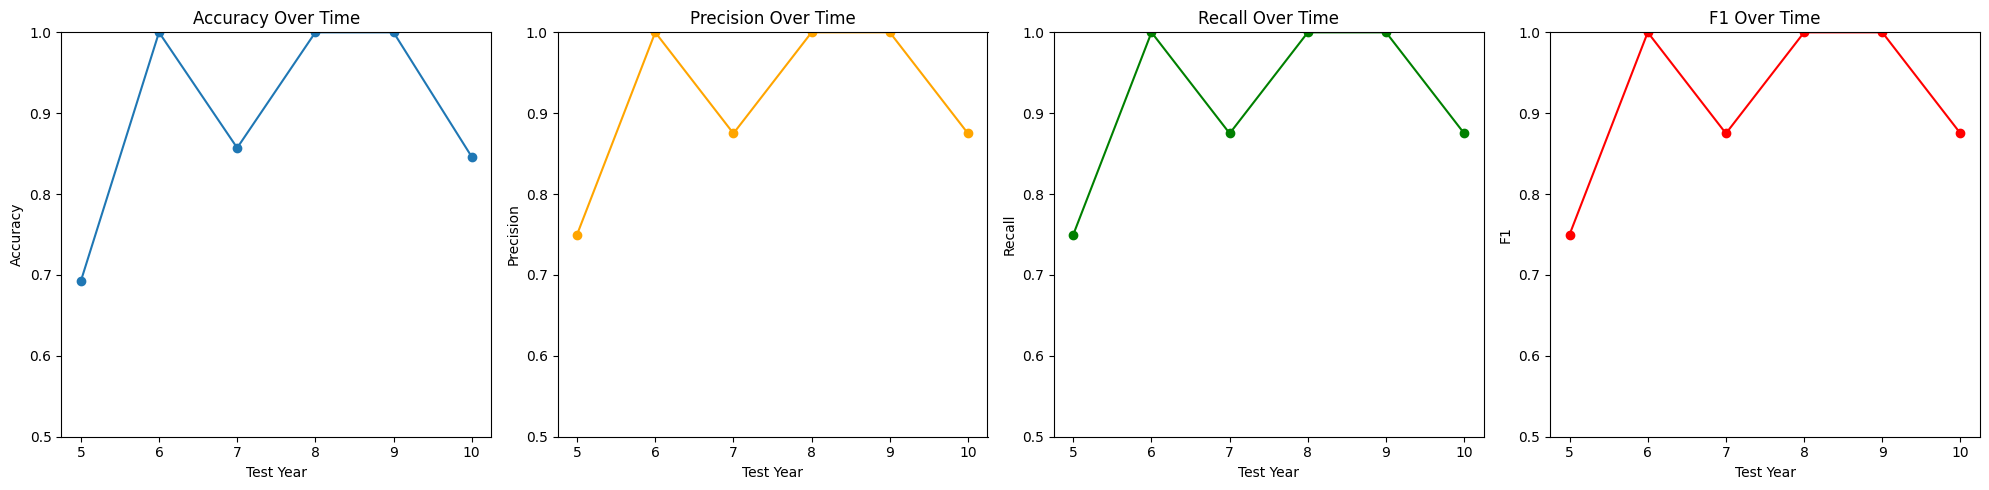

Accuracy:  0.8992673992673992
Precision:  0.9166666666666666
Recall:  0.9166666666666666
F1:  0.9166666666666666


In [132]:
model = RandomForestClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

### KNN

#### Hyperparameter tuning

In [133]:

# model = KNeighborsClassifier()

# param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'leaf_size': [10, 20, 30, 40, 50],
#               'p': [1, 2, 3],
#               'metric': ['minkowski', 'euclidean', 'manhattan']          
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)
# KNeighborsClassifier(leaf_size=10, n_neighbors=10, p=3, weights='distance') 0.7864615384615383



[1 2 0 3 4 5]
[6 2 4 1 0 3 5]
[3 4 1 0 5 2]
[3 5 1 4 0 2 6]
[4 1 5 0 2 3 6]
[2 0 5 3 6 1 4]
[3 4 2 0 5 1]
[4 0 1 3 5 2 6]
[3 4 2 1 5 0 6]
[4 2 6 0 1 5 3]
[3 2 0 5 4 1 6]
[0 5 2 4 1 3]


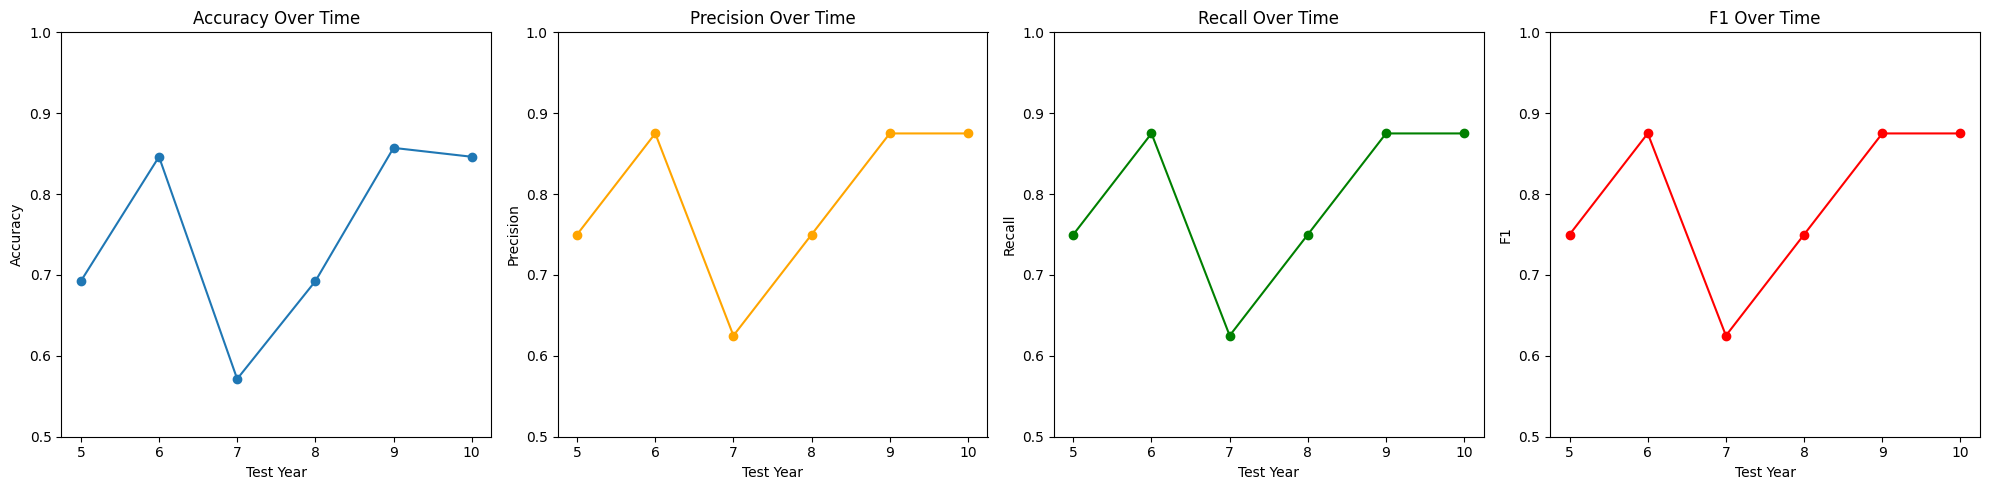

Accuracy:  0.7509157509157509
Precision:  0.7916666666666666
Recall:  0.7916666666666666
F1:  0.7916666666666666


In [134]:
model = KNeighborsClassifier(leaf_size=10, n_neighbors=10, p=3, weights='distance')
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

### XGBoost

#### Hyperparameter tuning

In [135]:

# model = XGBClassifier()

# param_grid = {'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2, 5],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [3, 4, 5]
                    
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)




[4 1 3 2 0 5]
[1 0 6 2 3 4 5]
[3 4 1 2 5 0]
[1 3 5 4 0 6 2]
[2 4 3 0 6 1 5]
[2 5 0 6 3 4 1]
[4 2 3 1 0 5]
[0 4 2 5 6 1 3]
[4 1 3 2 0 5 6]
[0 4 6 1 2 3 5]
[3 2 1 4 0 5 6]
[4 2 0 5 3 1]


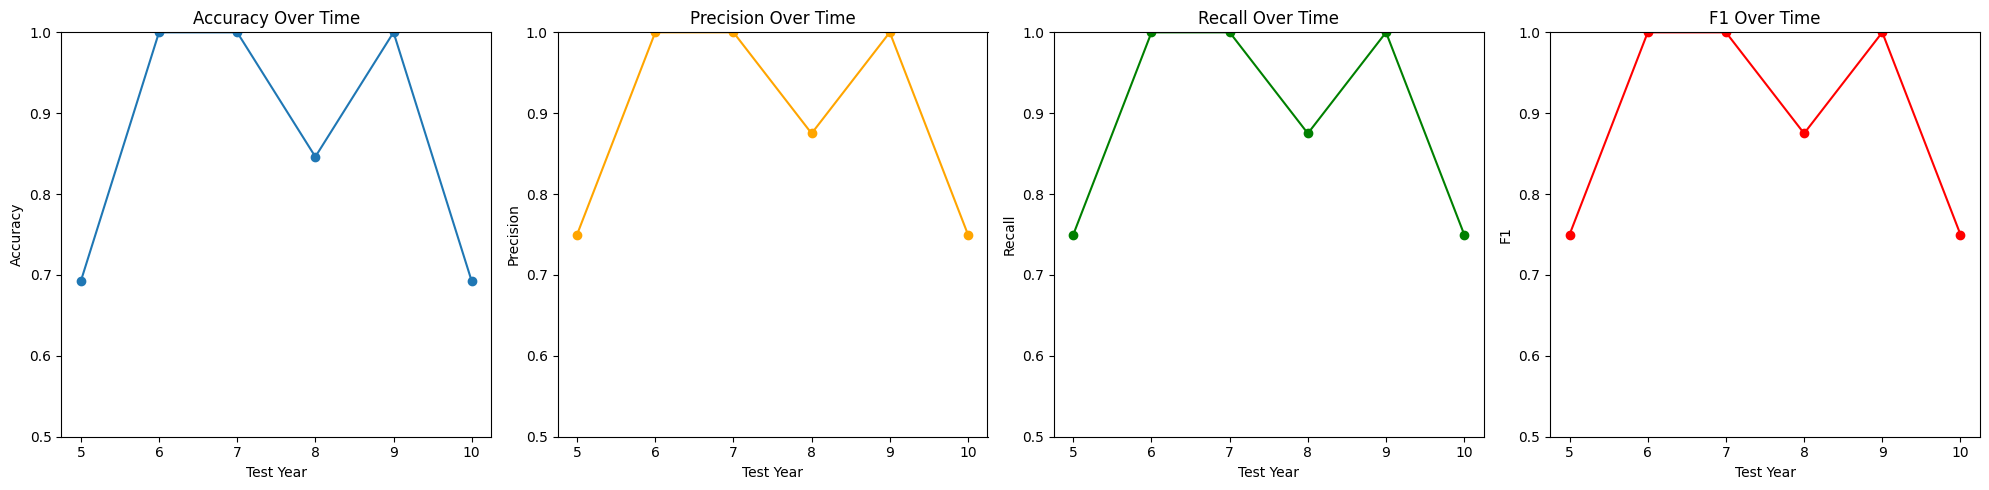

Accuracy:  0.8717948717948718
Precision:  0.8958333333333334
Recall:  0.8958333333333334
F1:  0.8958333333333334


In [136]:
model = XGBClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)


[0 1 3 4 5 2]
[0 2 4 6 1 5 3]
[1 3 4 2 0 5]
[1 3 4 5 0 2 6]
[0 1 2 3 4 5 6]
[0 2 5 6 3 4 1]
[1 2 3 4 0 5]
[0 4 1 5 6 2 3]
[1 2 3 4 0 5 6]
[0 1 2 4 6 5 3]
[2 3 0 1 4 5 6]
[0 2 4 5 1 3]


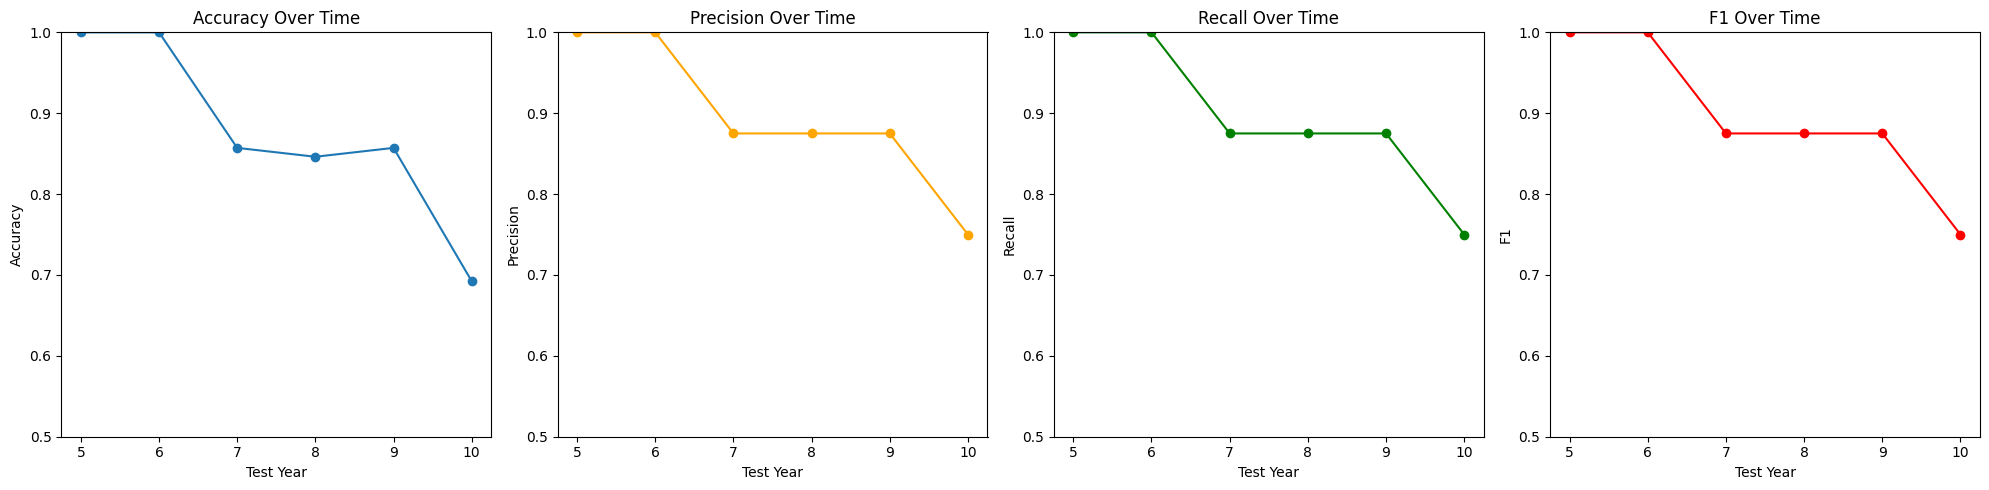

Accuracy:  0.8754578754578755
Precision:  0.8958333333333334
Recall:  0.8958333333333334
F1:  0.8958333333333334


In [137]:
model = GaussianNB()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[5 4 2 3 0 1]
[2 4 1 3 0 6 5]
[1 3 4 2 0 5]
[4 3 5 1 0 6 2]
[4 1 0 2 5 3 6]
[2 0 5 6 3 1 4]
[3 2 4 0 1 5]
[4 0 1 5 2 6 3]
[4 1 3 2 0 5 6]
[4 6 0 2 5 1 3]
[2 3 0 4 5 1 6]
[4 5 2 0 3 1]


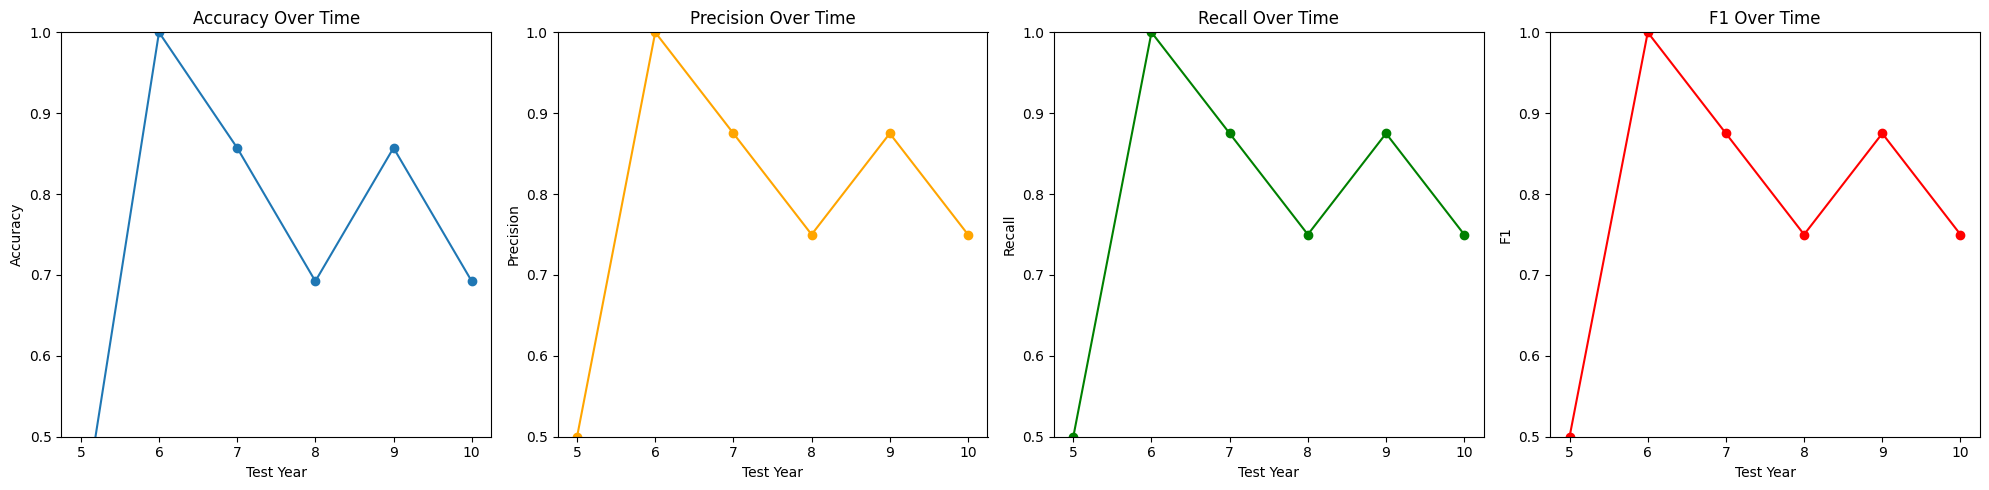

Accuracy:  0.7472527472527473
Precision:  0.7916666666666666
Recall:  0.7916666666666666
F1:  0.7916666666666666


In [138]:
model =SVC(probability=True)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[1 0 3 4 2 5]
[6 2 4 1 0 3 5]
[4 3 1 0 5 2]
[3 5 4 1 0 2 6]
[4 2 0 3 1 6 5]
[2 0 5 6 3 1 4]
[4 3 2 1 0 5]
[4 0 1 2 5 6 3]
[3 4 2 1 0 5 6]
[4 6 0 2 1 5 3]
[3 2 0 4 5 1 6]
[5 0 2 4 1 3]


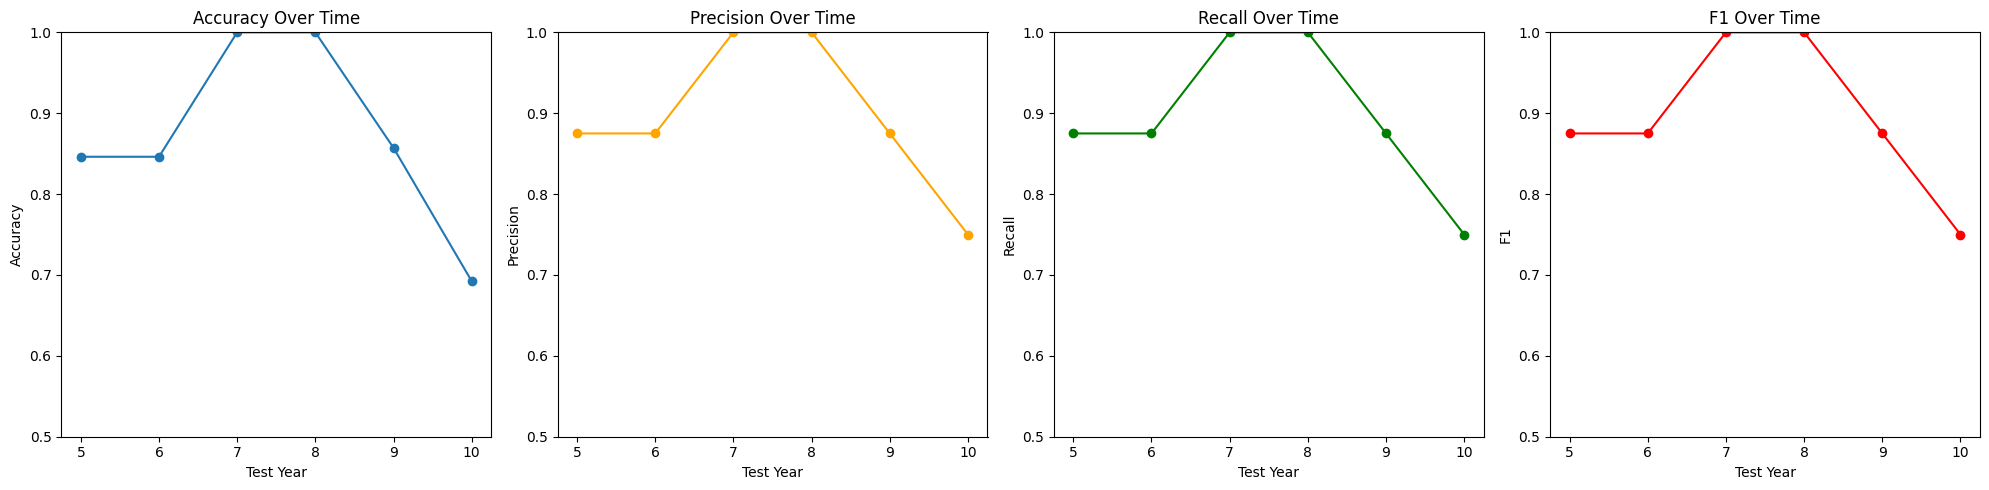

Accuracy:  0.8736263736263736
Precision:  0.8958333333333334
Recall:  0.8958333333333334
F1:  0.8958333333333334


In [139]:
model = LogisticRegression()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[1 0 3 2 4 5]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[6 3 0 2 1 4 5]
[4 3 1 0 5 2]
[5 3 4 1 0 6 2]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

[4 2 0 3 1 5 6]
[2 0 5 6 3 1 4]
[4 3 2 1 0 5]
[4 0 1 2 5 6 3]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[3 1 2 4 0 5 6]
[4 6 1 3 5 2 0]
[3 2 5 4 0 1 6]
[5 0 2 4 3 1]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


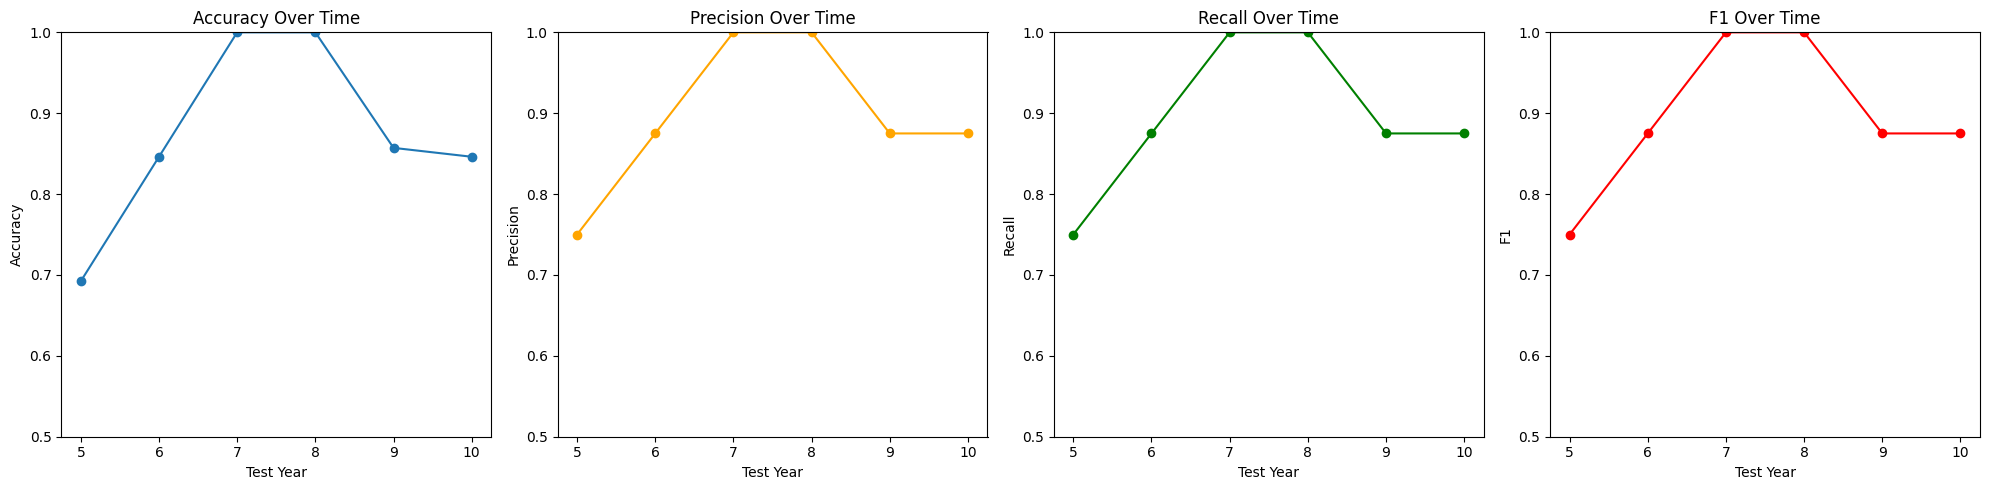

Accuracy:  0.8736263736263735
Precision:  0.8958333333333334
Recall:  0.8958333333333334
F1:  0.8958333333333334


In [140]:
model = MLPClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)